## Data analysis of Tropical Cyclone Best Track (TCBT) data (processed)

In [1]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import xarray as xr
import matplotlib.backends.backend_pdf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the options for BASIN
basin_options = {
    'Arabian Sea (AS)': 'AS',
    'Bay of Bengal (BoB)': 'BoB',
    'Both AS & BoB': 'BOTH'
}

# Define the options for TRACK_DATA
track_data_options = {
    'India Meteorological Department (IMD)': 'IMD',
    'Joint Typhoon Warning Center (JTWC)': 'JTWC',
    'International Best Track Archive for Climate Stewardship (IBTrACS)': 'IBTrACS'
}

# Create the dropdown widgets
basin_widget = widgets.Dropdown(
    options=basin_options.keys(),
    description='BASIN:'
)

track_data_widget = widgets.Dropdown(
    options=track_data_options.keys(),
    description='BT DATASET:'
)

# Initialize variables to store the selections
BASIN = None
TRACK_DATA = None

# Function to update variables based on selections
def update_variables(basin, track_data):
    global BASIN, TRACK_DATA
    BASIN = basin_options[basin]
    TRACK_DATA = track_data_options[track_data]
    
    print(f"ORIGIN BASIN selected\t\t: {BASIN}")
    print(f"BEST TRACK DATASET selected\t: {TRACK_DATA}")

# Display the dropdowns and set up interaction
interactive_widget = widgets.interactive(update_variables, basin=basin_widget, track_data=track_data_widget)
display(interactive_widget)


interactive(children=(Dropdown(description='BASIN:', options=('Arabian Sea (AS)', 'Bay of Bengal (BoB)', 'Both…

In [3]:
# Reading in the processed data based on the options selected above and setting DATETIME as index.
# NOTE: If you want to look at a different basin/dataset, change the option above and re-run the
# code from this cell to the end of this notebook SEQUENTIALLY (as some variable names are being
# reused in some instances for making different plots).
bt_data = pd.read_csv('./processed/{}_TCBT_AS_BOB_1982-2023.csv'.format(TRACK_DATA))
bt_data['DATETIME'] = pd.to_datetime(bt_data['DATETIME'])
bt_data.set_index('DATETIME', inplace = True)

# Selecting data based on the ORIGIN_BASIN selection.
if BASIN != 'BOTH':
    bt_data = bt_data[bt_data['ORIGIN_BASIN'] == BASIN.upper()]

figures = []

### Centering TC data about its Lifetime Maximum Intensity point <br> (while cropping out any D or DD that don't develop into a CS)

In [4]:
tcs_lmi_centred = [] # Empty list to hold all the dataframes of individual TCs, after centering them about their LMI point.
count = 0 # To count the number of cyclone systems that don't mature into a cyclonic storm

# Loops through different TCs, uniquely grouped based on the cyClone ID (CS_ID)
for tc_id, tc_data in bt_data.groupby(bt_data['CS_ID']): 
    # The below if-statement is to check if any D or DD develops into a CS during it's lifetime.
    if any('CS' in item for item in set(bt_data[bt_data['CS_ID'] == tc_id]['CAT'].values)) == True:
        lmi_index = tc_data['MSWS'].idxmax() # To find the index of 
        # Finding the difference in time between when LMI was reached and all other timesteps of data points before/after LMI.
        tc_data['TimeRelativeToLMI'] = (tc_data.index - lmi_index).total_seconds() / (3600 * 24) # Converting it to days.
        tcs_lmi_centred += [tc_data]
    else:
        count += 1

print('{} systems out of {} didn\'t mature into a CS'.format(count, len(list(bt_data['CS_ID'].unique()))))
tcs_lmi_centred = pd.concat(tcs_lmi_centred) # Concatenating into a single dataframe of TCs centered about their respective LMI.

43 systems out of 90 didn't mature into a CS


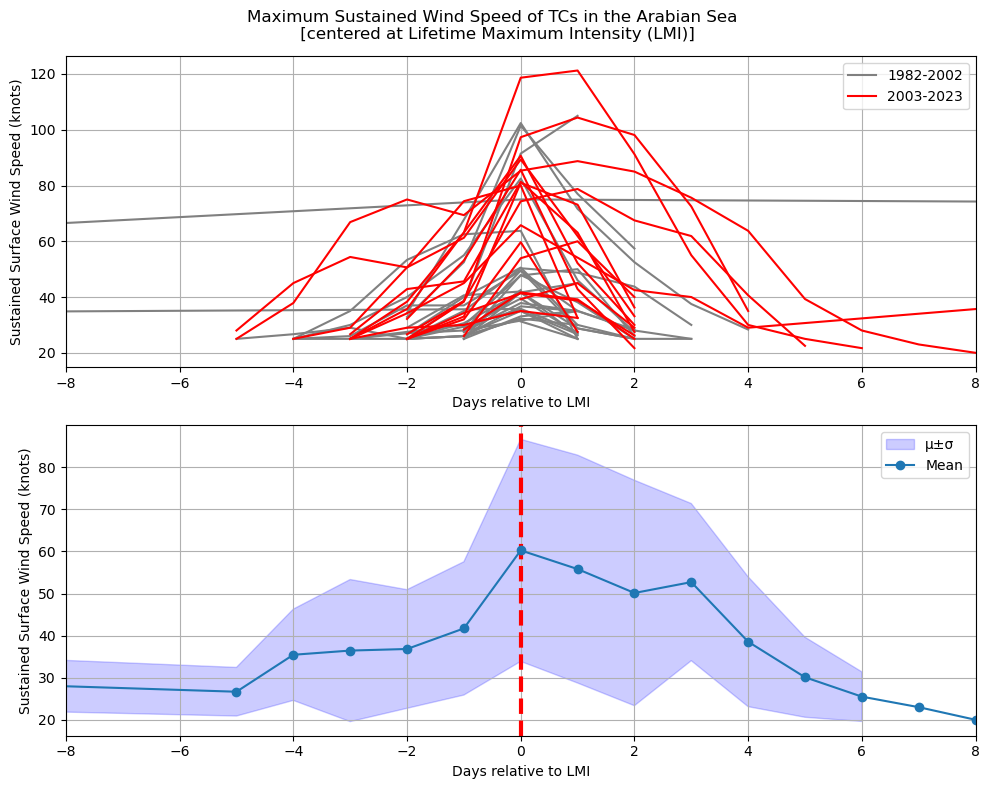

In [5]:
# Plotting Maximum Sustained Wind Speed of TCs as line plot and an ensemble mean+spread.

fig, axes = plt.subplots(2,1, figsize = (10,8))

if BASIN == 'BOTH':
    fig.suptitle('Maximum Sustained Wind Speed of TCs in the Arabian Sea and the Bay of Bengal \n [centered at Lifetime Maximum Intensity (LMI)]')
elif BASIN == 'AS':
    fig.suptitle('Maximum Sustained Wind Speed of TCs in the Arabian Sea \n [centered at Lifetime Maximum Intensity (LMI)]')
elif BASIN == 'BoB':
    fig.suptitle('Maximum Sustained Wind Speed of TCs in the Bay of Bengal \n [centered at Lifetime Maximum Intensity (LMI)]')

axes = axes.flatten()
for tc_id, tc_data in tcs_lmi_centred.groupby('CS_ID'):
    tc_data = tc_data[['MSWS', 'TimeRelativeToLMI']]
    tc_data.set_index('TimeRelativeToLMI', inplace = True)
    tc_data = tc_data.groupby(tc_data.index.astype(int)).mean() # Calculating daily mean values.
    if (int(str(tc_id)[0:4]) >= 1982) & (int(str(tc_id)[0:4]) <= 2012): # Grouping the TCs into two 'regimes', like recent past and historical.
        axes[0].plot(tc_data.index, tc_data['MSWS'], label = '1982-2002', color = 'gray')
    else:
        axes[0].plot(tc_data.index, tc_data['MSWS'], label = '2003-2023', color = 'red')

handles, labels = axes[0].get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
axes[0].legend(unique_labels.values(), unique_labels.keys())

axes[0].set_xlim([-8,8])
axes[0].set_xlabel('Days relative to LMI')
axes[0].set_ylabel('Sustained Surface Wind Speed (knots)')
axes[0].grid(True)
####################
mean = tcs_lmi_centred.drop(['CAT', 'ORIGIN_BASIN', 'CS_ID'], axis = 1).groupby('TimeRelativeToLMI').mean()['MSWS']
std = tcs_lmi_centred.drop(['CAT', 'ORIGIN_BASIN', 'CS_ID'], axis = 1).groupby('TimeRelativeToLMI').std()['MSWS']

mean = mean.groupby(mean.index.astype(int)).mean() # Calculating daily mean values.
std = std.groupby(std.index.astype(int)).mean() # Calculating daily mean values

axes[1].axvline(0, color = 'red', ls = '--', lw = 3)
axes[1].fill_between(std.index, (mean-std), (mean+std), alpha = 0.2, color = 'blue', label = 'µ±σ')
axes[1].plot(mean.index, mean, marker = 'o', label = 'Mean')
axes[1].legend()
axes[1].set_xlim([-8,8])
axes[1].set_xlabel('Days relative to LMI')
axes[1].set_ylabel('Sustained Surface Wind Speed (knots)')
axes[1].grid(True)
fig.tight_layout()
figures += [fig]

# Classifying TCs based on MHW influence

### Definition used for classification (Choi et al., 2024): <br>
<u>MHC TC</u>: Tropical cyclones whose centres stayed within 'n'˚ of an MHW area for ≥ 'd' days before reaching the LMI. 'n' and 'd' used in Choi et al., 2024 were 1˚ and 2 days.<br> <br>
<u>NON-MHC TC</u>: Tropical cyclones which has never encountered MHWs.
 <br>

Also,tropical cyclones that encountered an MHW region less than 24 hrs before reaching the LMI or TCs that passed an MHW region after the LMI have been excluded from this study (the OTHER class).


### Citation:
Choi, HY., Park, MS., Kim, HS. et al. Marine heatwave events strengthen the intensity of tropical cyclones. Commun Earth Environ 5, 69 (2024). https://doi.org/10.1038/
s43247-024-01239-4

In [6]:
#### VARIABLES FOR CLASSIFICATION CRITERION ####

proximity_thres_to_mhw = 0.25 
# How close-by the TC has to go to an MHW to be classed as one that's potentially influenced by that MHW?

d = 1 # How many days worth of data (atleast) before reaching LMI point is required? 
#'d' is also used to check if the TC BT stays within proximity_thres_to_mhw degrees of an MHW area for these many days, before classifying it into a MHW TC or not.

In [7]:
# Loading in the MHW masks (Courtesy: https://github.com/ligin1/Marine-Heat-Waves by Ligin Joseph from Uni of Soton and NOCS UK)
mhw_mask = {}
for x in ['AS', 'BoB']:
    mhw_mask[x] = xr.open_dataset('./mhw_data/mhw_1982_2023_{}.nc'.format(x)).rename({'__xarray_dataarray_variable__':'mhw_mask'})
    mhw_mask[x]['time'] = pd.to_datetime([str(x).split('T')[0] for x in mhw_mask[x].time.values])

### Selecting only the cyclones which had atleast 'd' days worth of data before reaching LMI point

In [8]:
df = pd.DataFrame(columns = ['TC_ID', 'FLAG'])
for tc_id, tc_data in tcs_lmi_centred.groupby(tcs_lmi_centred['CS_ID']):
    tvals = tc_data[tc_data.TimeRelativeToLMI <= 0].index # Selecting only tc_data before LMI.
    if (tvals[-1] - tvals[0]).total_seconds()/3600 >= 24*d: 
        # Difference between when first and last entry (LMI) is recorded should be >= 24*d hrs
        tdelta = 1 # Flagging if the TC has 'd' days worth of data before reaching LMI or not.
    else:
        tdelta = 0
    df.loc[len(df)] = [tc_id, tdelta]

# Selecting LMI-centred TC data based on FLAG values determined through the above loop.
tcs_lmi_centred_selected = tcs_lmi_centred[tcs_lmi_centred['CS_ID'].isin(df[df['FLAG'] == 1]['TC_ID'].values)]

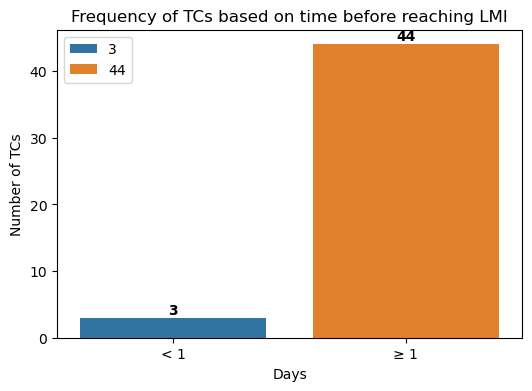

In [9]:
# Plot to illustrate the frequency of TCs based on how much time they take before reaching LMI
# Basically, it gives an idea of how many TCs satisfy the 'd' days condition described in the above cells.

counts = df['FLAG'].value_counts().sort_index()

# Map the values to '< d' and '≥ d'
labels = {0: '< {}'.format(d), 1: '≥ {}'.format(d)}
counts.index = counts.index.map(labels)

fig, ax = plt.subplots(1,1,figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values, palette='tab10', hue = counts.values)

# Annotate the bars with the count
for i, value in enumerate(counts.values):
    ax.text(i, value + 0.1, f'{value}', ha='center', va='bottom', fontweight='bold')

ax.set_title('Frequency of TCs based on time before reaching LMI')
ax.set_xlabel('Days')
ax.set_ylabel('Number of TCs')
figures += [fig]

### Checking the percentage of points that pass over an MHW (using 'nearest' gricell method to determine)

In [10]:
# Function to get the MHW mask value at the point closest to where a particular TC's best track passes through.
def get_mhw_mask_val(data_entry_row, origin_basin):
    if origin_basin == 'AS':
        return mhw_mask['AS'].sel(lat = data_entry_row[1]['LAT'], lon = data_entry_row[1]['LON'], time = data_entry_row[0], method = 'nearest')['mhw_mask'].item()
    elif origin_basin == 'BOB':
        return mhw_mask['BoB'].sel(lat = data_entry_row[1]['LAT'], lon = data_entry_row[1]['LON'], time = data_entry_row[0], method = 'nearest')['mhw_mask'].item()

In [11]:
df = pd.DataFrame(columns = ['TC_ID', 'PERCENT_POINTS_OVER_MHW'])
# Again, looping through different tropical cyclones.
for tc_id, tc_data in tcs_lmi_centred_selected.groupby(tcs_lmi_centred_selected['CS_ID']):
    mhw_mask_vals = []
    for x in tc_data.iterrows(): # Looping though each cyclones' data entries (i.e. rows).
        mhw_mask_vals = mhw_mask_vals + [get_mhw_mask_val(data_entry_row = x, origin_basin = x[1]['ORIGIN_BASIN'])]

    mhw_mask_vals = np.array(mhw_mask_vals)
    mhw_mask_vals[np.isnan(mhw_mask_vals)] = 0 # This takes care of any NaN values found in MHW mask over LAND.
    threshold = (mhw_mask_vals.sum()*100)/mhw_mask_vals.shape[0]
    df.loc[len(df)] = [tc_id, np.round(threshold,2)]

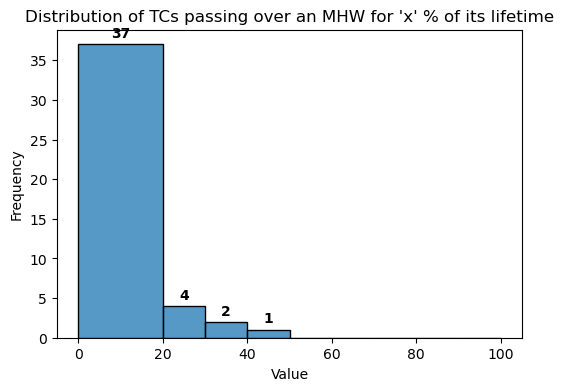

In [12]:
# Plot to show the distribution of TCs passing DIRECTLY over the MHW for 'x'% of its lifetime.
# e.g., if the 0-20% bar in the plot below show value as 40, it means that 40 TCs pass over 
# a MHW region about 0-20% of the time.
fig, ax = plt.subplots(1,1, figsize=(6, 4))
histplot = sns.histplot(df['PERCENT_POINTS_OVER_MHW'], bins = [0,20,30,40,50,60,70,80,90,100], kde=False)  # Adjust bins as needed

# Annotate bars with the count
for patch in histplot.patches:
    # Get the height of each bar (which corresponds to the count)
    height = patch.get_height()
    # Only annotate if the height is greater than 0
    if height > 0:
        # Get the x-position of the center of the bar
        ax.text(patch.get_x() + patch.get_width() / 2, height + 0.5,  # Adjust the position if needed
                 f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')


ax.set_xticks(np.arange(0, 101, 20))

ax.set_title("Distribution of TCs passing over an MHW for 'x' % of its lifetime")
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
figures += [fig]

In [13]:
# Function to calculate the distance in degrees between two points.
def distance_in_degrees(lat1, lon1, lat2, lon2):
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    # Adjust for the varying distance of longitude with latitude
    distance = np.sqrt(delta_lat**2 + (delta_lon * np.cos(np.radians(lat1)))**2)
    return distance

# Function to check if a TC track point is close to MHW, based on the proximity threshold you set above.
def check_if_point_close_to_mhw(x, thres = 1):
    origin_basin = x[1]['ORIGIN_BASIN']

    if origin_basin == 'AS':
        mask = mhw_mask['AS'].sel(time = '{}-{:02d}-{}'.format(x[0].year, x[0].month, x[0].day))['mhw_mask']
    elif origin_basin == 'BOB':
        mask = mhw_mask['BoB'].sel(time = '{}-{:02d}-{}'.format(x[0].year, x[0].month, x[0].day))['mhw_mask']

    # Given point (lat, lon)
    point_lon, point_lat = x[1]['LON'], x[1]['LAT']

    # Loop through all grid points and check if within 1-degree radius
    found_1_within_radius = False
    for lat_idx, lat in enumerate(mask['lat'].values):
        for lon_idx, lon in enumerate(mask['lon'].values):
            distance = distance_in_degrees(point_lat, point_lon, lat, lon)
            if distance <= thres:  # Check within {thres}-degree radius
                if mask[lat_idx, lon_idx] == 1:
                    found_1_within_radius = True
                    break
        if found_1_within_radius:
            break

    if found_1_within_radius:
        return 1
    else:
        return 0 

### Classifying and labelling TCs into NON-MHW, MHW and OTHER

In [14]:
# Classifying based on proximity threshold to MHW, using the functions defined above.

df = pd.DataFrame(columns = ['CS_ID', 'CLASS'])
for tc_id, tc_data in tcs_lmi_centred_selected.groupby(tcs_lmi_centred_selected['CS_ID']):
    mhw_flag = []
    for x in tc_data.iterrows():
        mhw_flag = mhw_flag + [check_if_point_close_to_mhw(x, thres = proximity_thres_to_mhw)]
    tc_data['MHW_FLAG'] = mhw_flag
    if tc_data[tc_data.TimeRelativeToLMI < 0]['MHW_FLAG'].sum() >= 8*d:
        # Condition for MHW TC: Atleast the last 'd' days' entries (1 day = 8 entries)
        # before LMI point is reached are close to any MHW-identified gridcells
        df.loc[len(df)] = [tc_id, 'MHW']
    elif tc_data['MHW_FLAG'].sum() == 0:
        # Condition for NON-MHW TC: At no point is a TC's best track is 
        # close to a MHW-identified gridcell
        df.loc[len(df)] = [tc_id, 'NON-MHW']
    else:
        # Other TCs that come close to an MHW atleast once, but are not 
        # thoroughly (atleast by the definition we chose) impacted by 
        # the MHW (like MHW TCs).
        df.loc[len(df)] = [tc_id, 'OTHER']

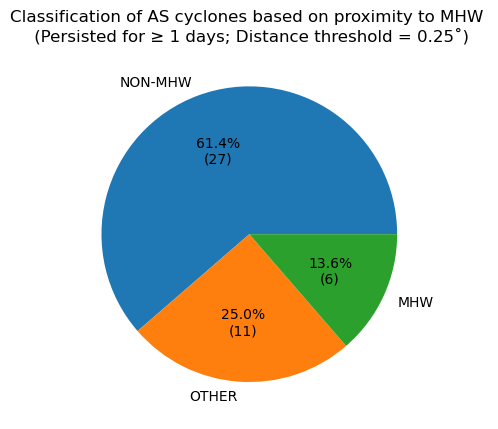

In [15]:
# Pie-chart distribution of MHW, NON-MHW and OTHER (i.e. partly influenced) TCs.
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

fig, ax = plt.subplots(1,1)

s = df['CLASS'].value_counts()
if BASIN != 'BOTH':
     ax.set_title('Classification of {} cyclones based on proximity to MHW \n (Persisted for ≥ {} days; Distance threshold = {}˚)'.format(BASIN, d, proximity_thres_to_mhw))
else:
     ax.set_title('Classification of {} cyclones based on proximity to MHW \n (Persisted for ≥ {} days; Distance threshold = {}˚)'.format('AS & BoB', d, proximity_thres_to_mhw))
ax.pie(s,labels = s.index, autopct=autopct_format(s))
figures += [fig]

In [16]:
# Indexing tcs_lmi_centred_selected dataframes based on CLASS of influence, concatenating and saving it as dataframes in a dictionary.

tcs_classified = {'MHW':[], 'NON-MHW':[], 'OTHER':[]}

for tc_class in tcs_classified.keys():
    for idx in df['CS_ID'][df['CLASS'] == tc_class].values:
        tcs_lmi_centred_selected[tcs_lmi_centred_selected['CS_ID'] == idx]
        tcs_classified[tc_class] += [tcs_lmi_centred_selected[tcs_lmi_centred_selected['CS_ID'] == idx]]
    tcs_classified[tc_class] = pd.concat(tcs_classified[tc_class])

In [17]:
# Saving the classified output as a .csv file
if BASIN != 'BOTH':
    df.to_csv('./output/{}_{}_pt{:03d}_d{:02d}_CS_ID_CLASSIFIED.csv'.format(TRACK_DATA, BASIN, int(100*proximity_thres_to_mhw), d))
else:
    df.to_csv('./output/{}_{}_pt{:03d}_d{:02d}_CS_ID_CLASSIFIED.csv'.format(TRACK_DATA, 'AS_AND_BOB', int(100*proximity_thres_to_mhw), d))

## Plotting TC MSWS as an ensemble after grouping by MHW-influence class (MHW TC or NON-MHW TC)

In [18]:
# Plotting function to plot grouped ensembles based on MHW-influence class
def ensemble_plotter(tc_data = None, ax = None, c = None, tc_type = None, daily = False):
    mean = tc_data.drop(['CS_ID', 'CAT', 'ORIGIN_BASIN'], axis = 1).groupby('TimeRelativeToLMI').mean()['MSWS']
    std = tc_data.drop(['CS_ID', 'CAT', 'ORIGIN_BASIN'], axis = 1).groupby('TimeRelativeToLMI').std()['MSWS']

    if daily == True: # Set if you want to plot daily-averaged wind-speed data.
        mean = mean.groupby(mean.index.astype(int)).mean()
        std = std.groupby(std.index.astype(int)).mean()
    
    ax.fill_between(std.index, (mean-std), (mean+std), alpha = 0.2, color = c, label = tc_type+': µ±σ')
    ax.plot(mean.index, mean, marker = 'o', label = tc_type+': Mean', color = c)

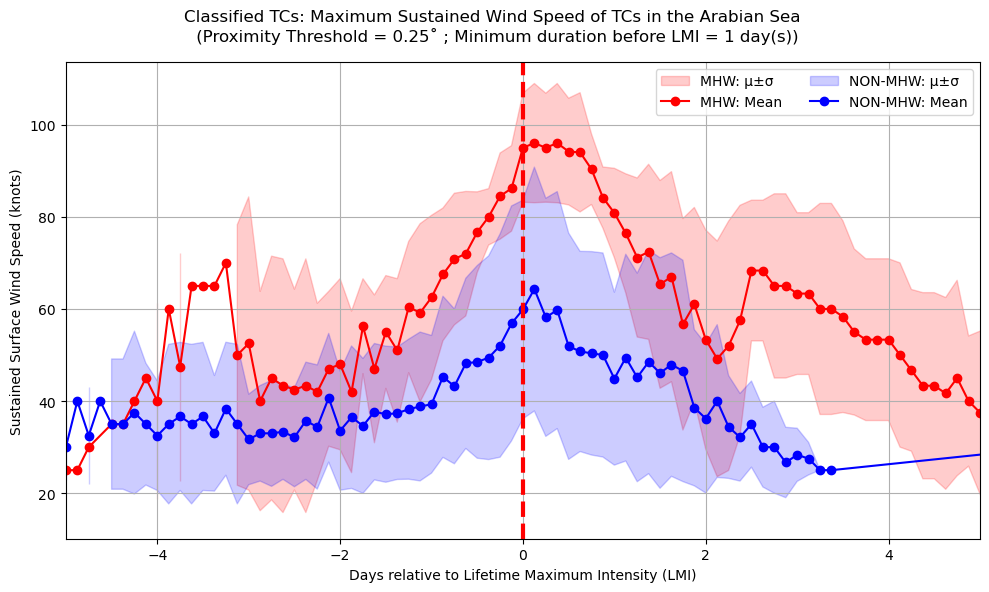

In [19]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
if BASIN == 'BOTH':
    fig.suptitle('Classified TCs: Maximum Sustained Wind Speed of TCs in the Arabian Sea and the Bay of Bengal \n (Proximity Threshold = {}˚ ; Minimum duration before LMI = {} day(s))'.format(proximity_thres_to_mhw, d))
elif BASIN == 'AS':
    fig.suptitle('Classified TCs: Maximum Sustained Wind Speed of TCs in the Arabian Sea \n (Proximity Threshold = {}˚ ; Minimum duration before LMI = {} day(s))'.format(proximity_thres_to_mhw, d))
elif BASIN == 'BoB':
    fig.suptitle('Classified TCs: Maximum Sustained Wind Speed of TCs in the Bay of Bengal \n (Proximity Threshold = {}˚ ; Minimum duration before LMI = {} day(s))'.format(proximity_thres_to_mhw, d))

ensemble_plotter(tcs_classified['MHW'], ax, 'red', tc_type = 'MHW', daily = False)
ensemble_plotter(tcs_classified['NON-MHW'], ax, 'blue', tc_type = 'NON-MHW', daily = False)
#ensemble_plotter(tcs_classified['OTHER'], ax, 'green', tc_type = 'NON-MHW')
ax.axvline(0, color = 'red', ls = '--', lw = 3)
ax.legend(ncols = 2)
ax.set_xlim([-5,5])
ax.set_xlabel('Days relative to Lifetime Maximum Intensity (LMI)')
ax.set_ylabel('Sustained Surface Wind Speed (knots)')
ax.grid(True)
fig.tight_layout()
figures += [fig]

In [20]:
# Saving all the figures into a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages('./output/{}_{}_pt{:03d}_d{:02d}.pdf'.format(TRACK_DATA, BASIN, int(100*proximity_thres_to_mhw), d))
for fig in figures: 
    pdf.savefig(fig)
pdf.close()

---